In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.colors import rgb2hex
import matplotlib.patches as mpatches
import matplotlib.patches as mpl_patches
import matplotlib.dates as mdates
import time
import datetime
from datetime import timedelta
from collections import Counter
import seaborn as sns; sns.set()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from itertools import groupby
import itertools
import random

from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition, mark_inset
from matplotlib.legend import Legend

from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats

import import_ipynb
from utils_common import *

In [98]:
# National level data of COVID-19
_JHU_DATA_START_DATE = '2020-01-22'
# National level confirmed
_JHU_DATA_C_FILE_ = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
# National level dead
_JHU_DATA_D_FILE_ = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
# National level recovered (cured)
_JHU_DATA_R_FILE_ = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
subject_file_dict = {'confirmed': _JHU_DATA_C_FILE_, 'dead': _JHU_DATA_D_FILE_, 'recovered': _JHU_DATA_R_FILE_}
# WJP data of Rule of law index 
# https://worldjusticeproject.org/rule-of-law-index/factors/2020
_WJP_DATA_FILE_ = './data_rule_of_law/2020.csv'
# United Nations data of Population
# https://population.un.org/wpp/Download/Standard/CSV/
_WPP_DATA_FILE_ = './data_rule_of_law/WPP2019_population.csv'

# Where to save the dataframes and figures
_Figure_PATH_ = './figures_rule_of_law/'
_Data_PATH_ = './data_rule_of_law/'

In [99]:
# Population 
def load_wpp_raw():
    raw = pd.read_csv(_WPP_DATA_FILE_)
    raw = raw[raw['Time'] == 2019]
    raw = raw[['Location', 'PopTotal']]
    rename_dict = {'Location': 'country', 
                   'PopTotal': 'population'
                  }
    raw = raw.rename(columns = rename_dict)
    
    raw.at[raw.index[raw['country'] == 'Bolivia (Plurinational State of)'].tolist(), 'country'] = 'Bolivia'
    raw.at[raw.index[raw['country'].str.contains('d\'Ivoire')].tolist(), 'country'] = 'Cote d\'Ivoire'
    raw.at[raw.index[raw['country'] == 'Iran (Islamic Republic of)'].tolist(), 'country'] = 'Iran'
    raw.at[raw.index[raw['country'] == 'Venezuela (Bolivarian Republic of)'].tolist(), 'country'] = 'Venezuela'
    raw.at[raw.index[raw['country'] == 'Viet Nam'].tolist(), 'country'] = 'Vietnam'
    raw.at[raw.index[raw['country'] == 'United States of America (and dependencies)'].tolist(), 'country'] = 'United States'
    
    
    raw = raw.sort_values(by = 'country')
    raw = raw.reset_index(drop = True)
    return raw
# Rule of law index
def load_wjp_raw():
    raw = pd.read_csv(_WJP_DATA_FILE_, index_col = 'Country')
    raw = raw.T
    raw = raw.drop(np.nan, 1)
    #cols = [c for c in raw.columns if c[1] != '.']
    #raw = raw[cols]
    raw.reset_index(level=0, inplace=True)
    raw.columns.name = None
    rename_dict = {'index': 'country', 
                   'Country Code': 'country_code',
                   'Region': 'region',
                   'Income Group': 'income group'
                  }
    data = raw.rename(columns = rename_dict)
    data.at[data.index[data['country'] == 'The Bahamas'].tolist(), 'country'] = 'Bahamas'
    data.at[data.index[data['country'] == 'Czech Republic'].tolist(), 'country'] = 'Czechia'
    data.at[data.index[data['country'] == 'The Gambia'].tolist(), 'country'] = 'Gambia'
    data.at[data.index[data['country'] == 'Congo, Dem. Rep.'].tolist(), 'country'] = 'Congo'
    data.at[data.index[data['country'] == 'Kyrgyz Republic'].tolist(), 'country'] = 'Kyrgyzstan'
    data.at[data.index[data['country'] == 'St. Kitts and Nevis'].tolist(), 'country'] = 'Saint Kitts and Nevis'
    data.at[data.index[data['country'] == 'St. Lucia'].tolist(), 'country'] = 'Saint Lucia'
    data.at[data.index[data['country'] == 'St. Vincent and the Grenadines'].tolist(), 'country'] = 'Saint Vincent and the Grenadines'
    data.at[data.index[data['country'] == 'Venezuela, RB'].tolist(), 'country'] = 'Venezuela'
    
    columns = data.columns.tolist()
    columns = columns[4:]
    for col in columns:
        data[col] = pd.to_numeric(data[col])
    
    return data
# COVID-19 infection
def load_jhu_raw(subject = 'confirmed'):
    
    raw = pd.read_csv(subject_file_dict[subject])
  
    rename_dict = {'Province/State': 'province/state', 
                   'Country/Region': 'country/region',
                   'Lat': 'latitude',
                   'Long': 'longitude'
                  }
    data = raw.rename(columns = rename_dict)
    return data

# confirmed, dead, or cured
def jhu_country_single(subject = 'confirmed'):
    
    raw = load_jhu_raw(subject = subject)
    #raw = raw[raw['province/state'].isnull()].reset_index(drop = True)
    #raw = raw.drop('province/state', 1)
    raw = raw[(raw['province/state']!= 'Diamond Princess') & (raw['province/state']!= 'Grand Princess')]
    raw_country = raw[raw['province/state'].isnull()].reset_index(drop = True)
    raw.at[raw.index[raw['country/region'] == 'Congo (Brazzaville)'].tolist(), 'country/region'] = 'Congo'
    raw.at[raw.index[raw['country/region'] == 'Congo (Kinshasa)'].tolist(), 'country/region'] = 'Congo'
    data = raw.groupby(["country/region"]).sum().reset_index()
    names_missing = [temp for temp in list(set(raw['country/region'])) if temp not in list(set(raw_country['country/region']))]
    for name in names_missing:
        data.at[data.index[data['country/region'] == name].tolist(), 'latitude'] = np.nan
        data.at[data.index[data['country/region'] == name].tolist(), 'longitude'] = np.nan
    data.at[data.index[data['country/region'] == 'Russia'].tolist(), 'country/region'] = 'Russian Federation'
    data.at[data.index[data['country/region'] == 'US'].tolist(), 'country/region'] = 'United States'
 
    data = data.melt(id_vars =['country/region', 'latitude', 'longitude'])
    rename_dict = {'variable': 'update_date',
                   'value': 'cum_' + subject
                  }
    data = data.rename(columns = rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'])  # original type of update_time after read_csv is 'str'
    data['update_date'] = data['update_date'].dt.date
    new_col = ['update_date', 'country/region', 'latitude', 'longitude', 'cum_' + subject]
    data = data[new_col]
    data = data.sort_values(by = ['update_date', 'country/region'])
    data = data.reset_index(drop=True)
    return data

# confirmed, dead, and cured
def jhu_country_all():
    data_confirmed = jhu_country_single(subject = 'confirmed')
    data_dead = jhu_country_single(subject = 'dead')
    data_recovered = jhu_country_single(subject = 'recovered')
    data_confirmed['cum_dead'] =  data_dead['cum_dead']
    data_confirmed['cum_recovered'] = data_recovered['cum_recovered']
    data_city, data_province, data_province_domestic = load_DXY_raw()
    data_head = data_province.groupby('update_date')['cum_confirmed', 'cum_cured', 'cum_dead'].sum().reset_index().head(8)
    data_head['update_date'] = data_head['update_date'] - timedelta(days=1)
    data_head['country/region'] = 'China'
    data_head['latitude'] = np.nan
    data_head['longitude'] = np.nan
    data_head = data_head.rename(columns={'cum_cured': 'cum_recovered'})
    new_col = data_confirmed.columns
    data_head = data_head[new_col]
    data = pd.concat([data_head, data_confirmed])
    data = data[data['cum_confirmed']!=0].reset_index(drop = True)
    print('Last update: ', data['update_date'].max())
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    return data

# Calculate new confirmed, new dead, and new cured
# out = add_daily_new(out, group_keys=['country/region', 'province/state'])
def add_daily_new(df, group_keys=['province_name', 'city_name']):
    cols = ['confirmed', 'dead', 'cured']
    daily_new = df.groupby(group_keys).agg(dict([(n, 'diff') for n in ['cum_' + c for c in cols]]))
    daily_new = daily_new.rename(columns=dict([('cum_' + n, 'new_' + n) for n in cols]))
    df = pd.concat([df, daily_new], axis=1, join='outer')
    return df

In [100]:
data_wjp = load_wjp_raw()
data_wpp = load_wpp_raw()

In [101]:
data_world = jhu_country_all()

Last update:  2020-04-28
Data date range:  2020-01-14 to 2020-04-28
Number of rows in raw data:  10346


In [102]:
#data_world_single = data_world[data_world['update_date'] == max(data_world['update_date'] - timedelta(days=1))]
#data_world_single[data_world_single['latitude'].isnull()]

In [103]:
# Diamond Princess and Grand Princess are not countries
#data = load_jhu_raw(subject = 'confirmed')
#data = data[(data['province/state']!= 'Diamond Princess') & (data['province/state']!= 'Grand Princess')]
#data.groupby(["country/region"]).sum().reset_index()

In [104]:
# Get the names of countries from the COVID-19 data
names_country_infection = list(set(data_world['country/region']))
names_country_infection.sort()

In [105]:
# Get the intersection of names of countries from the three data sources: JHU COVID-19, WJP rule of law index, UN population
names_country = [item for item in data_wjp['country'].tolist() if (item in data_wpp['country'].tolist()) & (item in data_world['country/region'].tolist())]
names_country.sort()

In [106]:
# Get the complement of names of countries (WJP data)
[name for name in data_wjp['country'].tolist() if name not in names_country_infection]

['Hong Kong SAR, China', 'Myanmar', 'Republic of Korea']

In [107]:
[name for name in data_wjp['country'].tolist() if name not in names_country]

['Hong Kong SAR, China',
 'Kosovo',
 'Moldova',
 'Myanmar',
 'Republic of Korea',
 'Tanzania']

In [108]:
# Compress warnings: everyone will be tired of warnings at this stage...
# An interaged figure
import warnings
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.")
# Multivariable linear regression
# 1: 8 factors
# 2: 44 subfactors
def figure_fitting(df, df_rule_of_law, df_population, names_country, fsize, ms, fs, log = False):
    
    date_tr = max(df['update_date'] - timedelta(days=0))
    df = df[df['update_date'] == date_tr]
    df = df[df['country/region'].isin(names_country)].reset_index(drop=True)
    m = len(names_country)
    names_country = df.sort_values(by = 'cum_confirmed').reset_index(drop=True).tail(m)['country/region'].tolist()
    names_country.sort()
    df = df[df['country/region'].isin(names_country)].reset_index(drop=True)
    df = df.sort_values(by = 'country/region').reset_index(drop=True)
    #print (df)
    df['infection_rate'] = df.apply(lambda row: row['cum_confirmed']/df_population[df_population['country'] == row['country/region']]['population'].tolist()[0], axis=1)
    
    
    df_rule_of_law = df_rule_of_law[df_rule_of_law['country'].isin(names_country)].reset_index(drop=True)
    
    cols = [c for c in df_rule_of_law.columns if 'Factor' in c]
    
    if log == True:
        y = np.log10(df['infection_rate'])
    else:
        y = df['infection_rate']
    
    def summary(X, regressor, cols):
        
        params = np.append(regressor.intercept_, regressor.coef_)
        predictions = regressor.predict(X)

        X_new = pd.DataFrame({"constant":np.ones(len(X))}).join(pd.DataFrame(X))
        MSE = (sum((y-predictions)**2))/(len(X_new)-len(X_new.columns))

        var_b = MSE*(np.linalg.inv(np.dot(X_new.T,X_new)).diagonal())
        sd_b = np.sqrt(var_b)
        ts_b = params/sd_b

        p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X_new)-1))) for i in ts_b]

        sd_b = np.round(sd_b,3)
        ts_b = np.round(ts_b,3)
        p_values = np.round(p_values,3)
        params = np.round(params,4)

        df_summary = pd.DataFrame()
        df_summary['variable'] = ['intercept'] + cols
        df_summary["coefficient"], df_summary["sde"], df_summary["t value"] ,df_summary["p value"] = [params, sd_b, ts_b, p_values]
        return df_summary
    
    X = df_rule_of_law[cols].values
    regressor = LinearRegression()
    regressor.fit(X, y)
    df_coeff = pd.DataFrame(regressor.coef_, cols, columns=['coefficient'])
    y_pred = regressor.predict(X)
    rmse = round(np.sqrt(metrics.mean_squared_error(y, y_pred)), 4)
    df_summary = summary(X, regressor, cols)
    
    
    cols_sub = [c for c in df_rule_of_law.columns if c[1] == '.']
    X = df_rule_of_law[cols_sub].values
    regressor_sub = LinearRegression()  
    regressor_sub.fit(X, y)
    df_coeff_sub = pd.DataFrame(regressor_sub.coef_, cols_sub, columns=['coefficient'])
    y_pred_sub = regressor_sub.predict(X)
    rmse_sub = round(np.sqrt(metrics.mean_squared_error(y, y_pred_sub)), 4)
    
    df_summary_sub = summary(X, regressor_sub, cols_sub)
    
    if log == True:
        y_pred_list = [np.power(10, y_pred), np.power(10, y_pred_sub)]
    else:
        y_pred_list = [y_pred, y_pred_sub]
    
    rmse_list = [rmse, rmse_sub]
    
    df_coeff_list = [df_coeff, df_coeff_sub]
    
    df_summary_list = [df_summary, df_summary_sub]
                       
    df_rank = df.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    s = df['cum_confirmed'].tolist()
    s = [np.log10(temp)*ms for temp in s]
    
    title_list = ['Factors', 'Subfactors']
    
    label_list = [r'$y_i = \sum \beta_{i} x_{i}$', r'$y_i = \sum \beta_{ij} x_{ij}$']
    
    legend_list = [r'highest $\beta_i$:', r'highest $\beta_{ij}$:']
    
    fig, axes = plt.subplots(2, 1, figsize = fsize, sharey = False)
    sns.set_style("ticks")
    for i in range(2):
        if i == 0:
            palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
        else:
            palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
        colors = list(itertools.chain.from_iterable(itertools.repeat(x, int(np.ceil(df.shape[0]/4))) for x in palette)) 
        colors = colors[:df.shape[0]]
        colors = [colors[rank_list.index(i)] for i in range(0, df.shape[0])]
        ix = np.unravel_index(i, axes.shape)
        ax = axes[ix]
        # r'E[y] = ' + str(round(df['infection_rate'].mean(), 4)) +  
        ax.scatter(df['infection_rate'], y_pred_list[i], marker = 'o', s = s, 
                   label = 'RMSE = ' + str(rmse_list[i]),
                   color = colors, alpha = 0.8)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(0.0001, 10)
        ax.set_ylim(0.005, 10)
        
        influencers = df_coeff_list[i].sort_values(by = 'coefficient', ascending = False).head(4).index.tolist()
        #patch_list = [mpatches.Patch(color = palette[3], label = inf) for i, inf in enumerate(influencers)]
        
        
        #leg = Legend(ax, patch_list, influencers,
                     #loc = 'upper left', ncol = 1, bbox_to_anchor = (0, 0.9), fontsize = fs - 2, fancybox = True)
        #ax.add_artist(leg)
        
        textstr = "\n".join([legend_list[i]] + influencers)
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle = 'round', facecolor = palette[1], alpha=0.05)

        # place a text box in upper left in axes coords
        ax.text(0.015, 0.815, textstr, transform = ax.transAxes, fontsize = fs-2, 
                verticalalignment = 'center', bbox = props)
        
        
        if i == 1:
            ax.set_xlabel(r'$y = $' 'Infection rate (per mille)', fontsize = fs - 2)
            
        
        ax.set_ylabel(label_list[i], fontsize = fs - 2)
        axes[ix].get_yaxis().set_label_coords(-0.05,0.5)
        
        axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 2)
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        axes[ix].set_title(title_list[i], fontsize = fs)
        
    fig.suptitle('Multivariate linear regression: infection and the rule of law', fontsize = fs + 2, y = 1.03)
    plt.figtext(0.5, 1.005, 'Date: ' + date_tr.strftime("%d %B, %Y"), ha="center", va="top", fontsize = fs - 2)
    
    fig.savefig(_Figure_PATH_ + 'rol_mv_regression.png', dpi = 400, bbox_inches='tight')
    
    return df_summary_list

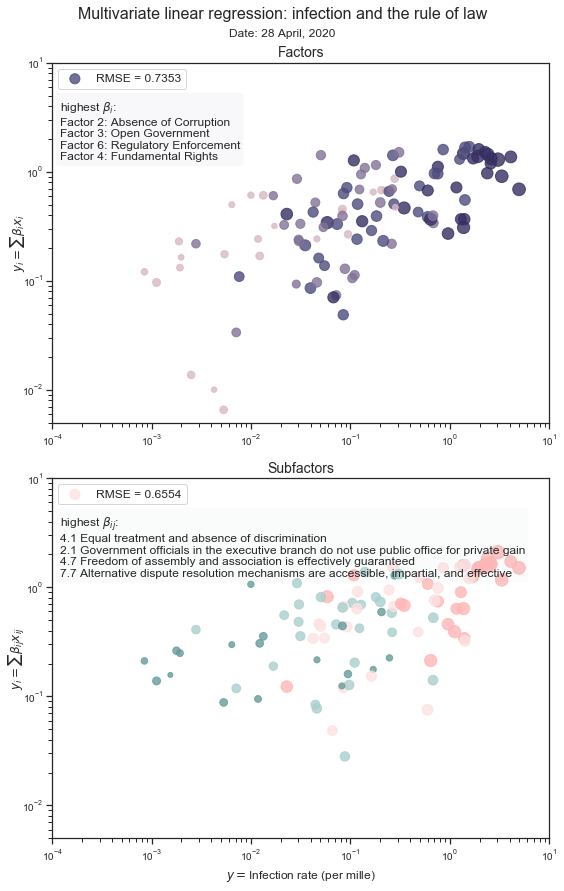

In [121]:
df_summary, df_summary_sub = figure_fitting(data_world, data_wjp, data_wpp, names_country, fsize = (8, 12), ms = 30, fs = 14, log = False)

In [110]:
# Single variable linear regression
# 44 subfactors
def figure_correlation_single_factor(df, df_rule_of_law, df_population, names_country, fsize, ncol, ms, fs, factor = 1):
    date_tr = max(df['update_date'] - timedelta(days=0))
    df = df[df['update_date'] == date_tr]
    df = df[df['country/region'].isin(names_country)].reset_index(drop=True)
    df['infection_rate'] = df.apply(lambda row: row['cum_confirmed']/df_population[df_population['country'] == row['country/region']]['population'].tolist()[0], axis=1)
    
    df_rule_of_law = df_rule_of_law[df_rule_of_law['country'].isin(names_country)].reset_index(drop=True)
    
    cols = [c for c in df_rule_of_law.columns if ('Factor ' + str(factor) in c) | (c[0] == str(factor))]
    
    m = len(cols)
    
    column_x = df['infection_rate']
    corr_list = [round(column_x.corr(df_rule_of_law[col]), 4) for i, col in enumerate(cols)]
    corr_list = corr_list[1:]
    i_most = corr_list.index(max(corr_list)) + 1
    
    
    
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    df_rank = df.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    s = df['cum_confirmed'].tolist()
    s = [np.log10(temp)*ms for temp in s]
    
    for i, col in enumerate(cols):
        
        if i == i_most:
            palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
        else:
            palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
        colors = list(itertools.chain.from_iterable(itertools.repeat(x, int(np.ceil(df.shape[0]/4))) for x in palette)) 
        colors = colors[:df.shape[0]]
        colors = [colors[rank_list.index(i)] for i in range(0, df.shape[0])]
        
        ix = np.unravel_index(i, axes.shape)
        ax = axes[ix]
        column_y = df_rule_of_law[col]
        corr = round(column_x.corr(column_y), 4)
        ax.scatter(column_x, column_y, marker = 'o', s = s, label = 'corr = ' + str(corr),
                   color = colors, alpha = 0.8)
        
        ax.set_xscale('log')
        ax.set_xlim(0.0001, 10)
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            ax.set_xlabel('Infection rate (per mille)', fontsize = fs - 2)
            
        if i % ncol == 0:
            ax.set_ylabel('WJP rule of law index', fontsize = fs - 2)
            axes[ix].get_yaxis().set_label_coords(-0.1,0.5)
            
        
        axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 2)
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        axes[ix].set_title(col, fontsize = fs - 4)
     
    fig.align_ylabels(axes[:, 0])
    
    fig.suptitle('Correlation between infection and the rule of law', fontsize = fs + 2, y = 1.03)
    plt.figtext(0.1, 1.03, 'Date: ' + date_tr.strftime("%d %B, %Y"), ha="center", va="top", fontsize = fs - 2)
    fig.savefig(_Figure_PATH_ + 'rol_subfactor_' + str(factor) + '.png', dpi = 400, bbox_inches='tight')

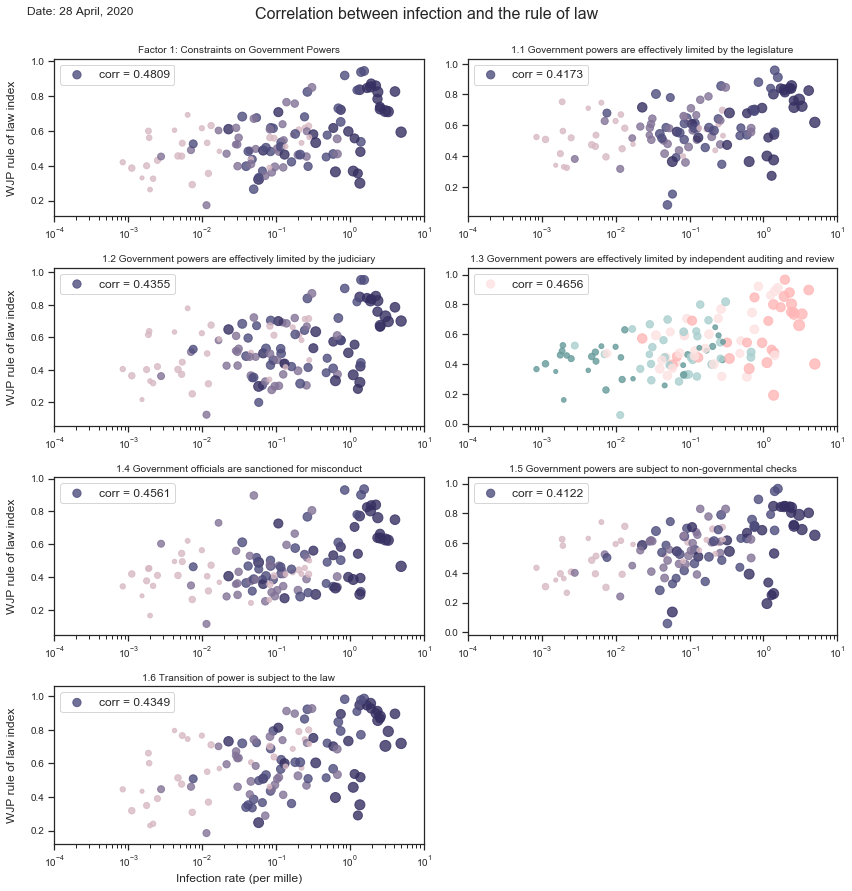

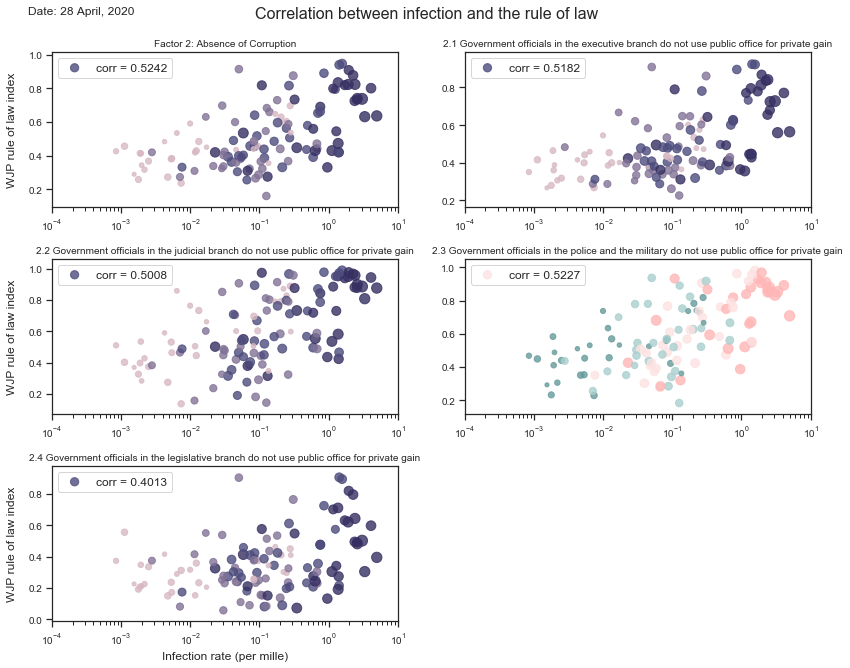

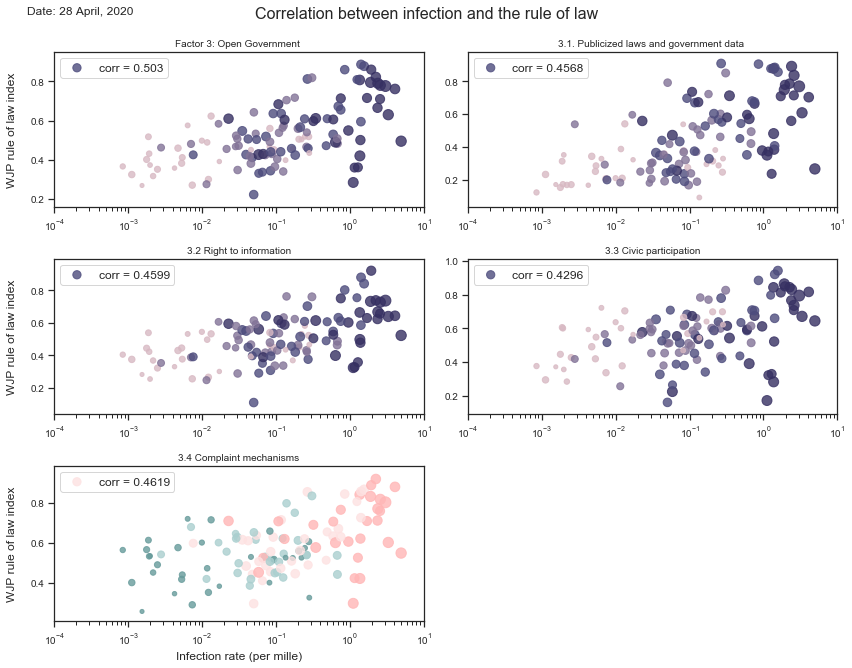

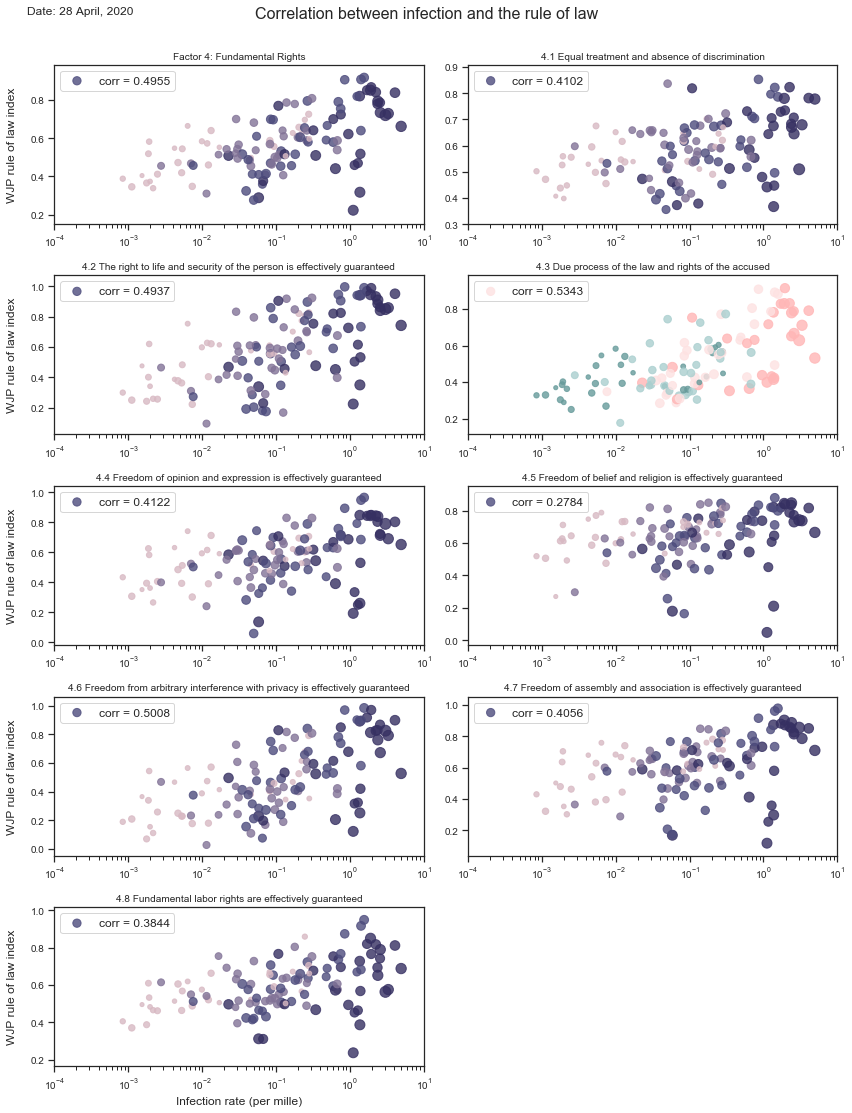

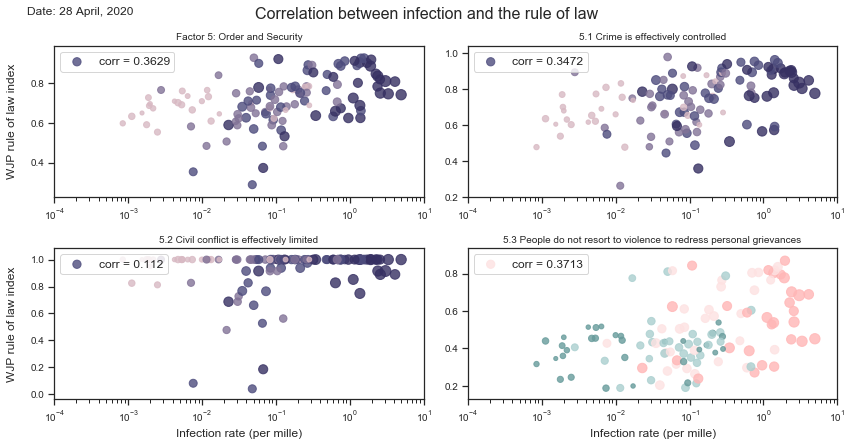

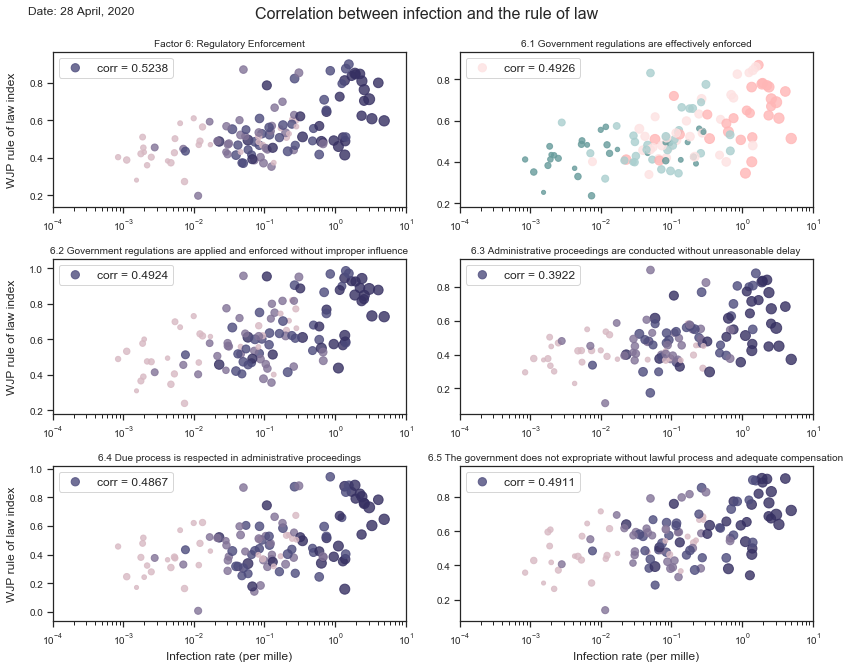

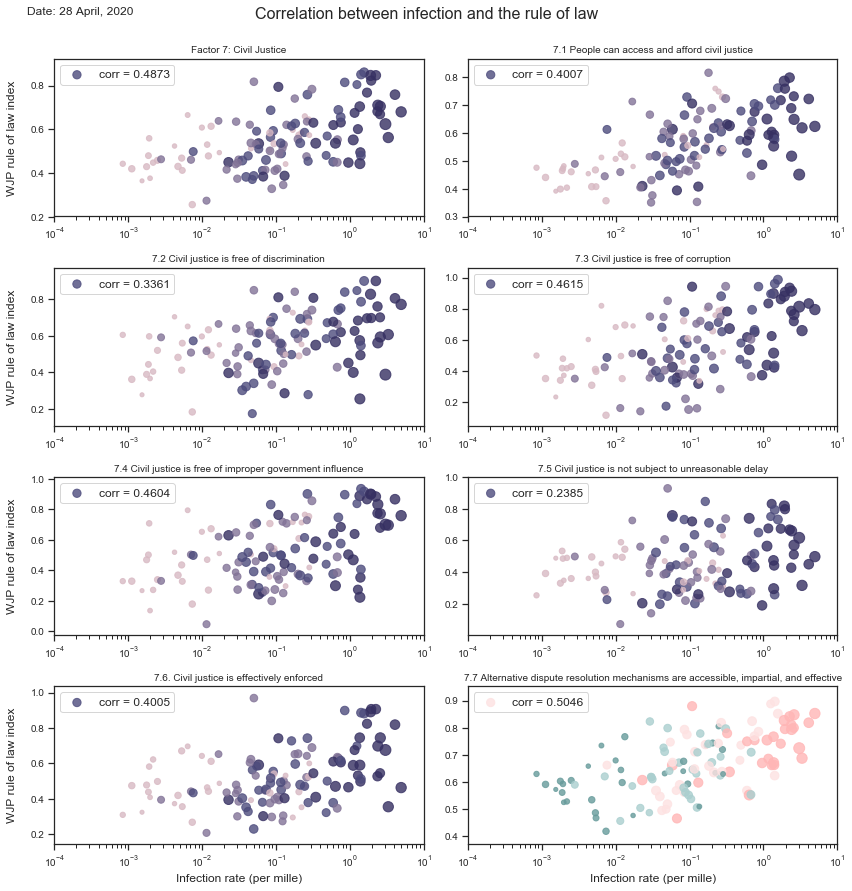

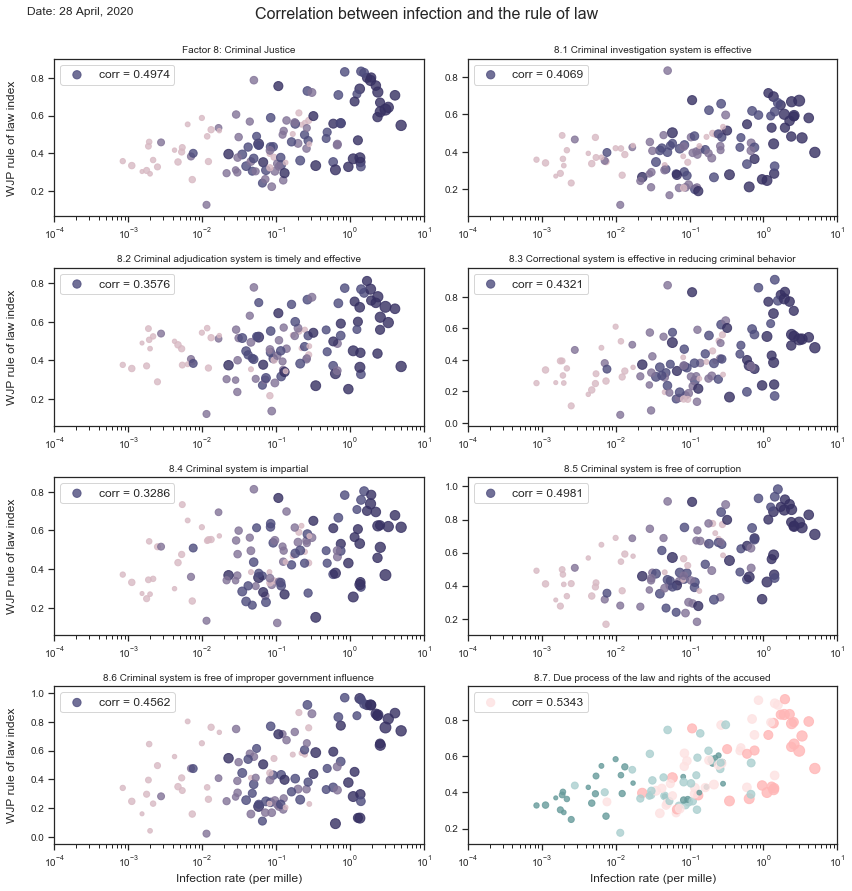

In [111]:
for i in range(1, 9):
    figure_correlation_single_factor(data_world, data_wjp, data_wpp, names_country,
                                     fsize = (6, 3), ncol = 2, ms = 20, fs = 14, factor = i)

In [112]:
# Single variable linear regression
# 1: overall score
# 1.1: every country is inclued
# 1.2: only the 10 countries with the highest numbers of infected people are considered
# 2: 8 factors
def figure_correlation_single(df, df_rule_of_law, df_population, names_country, fsize, ms, fs, col_index = 0, flag = 'total'):
    date_tr = max(df['update_date'] - timedelta(days=0))
    df = df[df['update_date'] == date_tr]
    df = df[df['country/region'].isin(names_country)].reset_index(drop=True)
    df['infection_rate'] = df.apply(lambda row: row['cum_confirmed']/df_population[df_population['country'] == row['country/region']]['population'].tolist()[0], axis=1)
    
    df_rule_of_law = df_rule_of_law[df_rule_of_law['country'].isin(names_country)].reset_index(drop=True)
    
    #fig, axes = plt.subplots(3, 1, figsize = fsize, sharey = False)
    fig = plt.figure(figsize = fsize)
    sns.set_style("ticks")
    
    palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    columns = df_rule_of_law.columns.tolist()
    cols = [c for c in df_rule_of_law.columns if (c[0] == 'F') | (c[0] == 'W')]
        
    
    ax = plt.subplot(111)
    
    column_x = df['infection_rate']
    column_y = df_rule_of_law[cols[col_index]]
    if flag == 'top':
        names = df.sort_values(by = 'cum_confirmed').reset_index(drop=True).tail(10)['country/region'].tolist()
        names.sort()
        text_x = df.index[df['country/region'].isin(names)].tolist()
        text_y = df_rule_of_law.index[df_rule_of_law['country'].isin(names)].tolist()
        column_x = df[df['country/region'].isin(names)]['infection_rate']
        column_y = df_rule_of_law[df_rule_of_law['country'].isin(names)][cols[col_index]]
        df_rank = df[df['country/region'].isin(names)].reset_index().sort_values(by = 'cum_confirmed')
        rank_list = df_rank.index.tolist()
        s = df[df['country/region'].isin(names)]['cum_confirmed'].tolist()
        s = [np.log10(temp)*ms for temp in s]
        colors = list(itertools.chain.from_iterable(itertools.repeat(x, int(np.ceil(10/4))) for x in palette)) 
        colors = colors[:10]
        colors = [colors[rank_list.index(i)] for i in range(0, 10)]
    else:
        df_rank = df.sort_values(by = 'cum_confirmed')
        rank_list = df_rank.index.tolist()
        #s = [ms*(rank_list.index(i) + 1) for i in range(0, df.shape[0])]
        s = df['cum_confirmed'].tolist()
        s = [np.log10(temp)*ms for temp in s]
        #print(s)
        colors = list(itertools.chain.from_iterable(itertools.repeat(x, int(np.ceil(df.shape[0]/4))) for x in palette)) 
        colors = colors[:df.shape[0]]
        colors = [colors[rank_list.index(i)] for i in range(0, df.shape[0])]
    
    corr = round(column_x.corr(column_y), 4)
    ax.scatter(column_x, column_y, marker = 'o', s = s, label = cols[col_index] + ' (corr = ' + str(corr) + ')',
    color = colors, alpha = 0.8)
    if flag == 'top':
        for pos, name in enumerate(names):
            if (column_x[text_x[pos]] >= column_x[text_x[names.index('France')]]) & (name!='United States') | (name == 'Turkey'):
                ax.annotate(name, (column_x[text_x[pos]], column_y[text_y[pos]]), 
                           va = 'bottom', ha = 'left', fontsize = fs - 4)
            else:
                ax.annotate(name, (column_x[text_x[pos]], column_y[text_y[pos]]), 
                                   va = 'top', ha = 'right', fontsize = fs - 4)
    
    
    ax.set_xlabel('Infection rate (per mille)', fontsize = fs - 2)
       
    ax.set_ylabel('WJP rule of law index', fontsize = fs - 2)
    if flag == 'total':
        ax.set_xscale('log')
        ax.set_xlim(0.0001, 10)
    else:
        ax.set_xscale('log')
        ax.set_xlim(0.01, 10)
    ax.legend(loc = 'upper left', fontsize = fs - 4, bbox_to_anchor=(0.0, 1), fancybox = True)

    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    ax.set_title('Date: ' + date_tr.strftime("%d %B, %Y"), fontsize = fs - 2) 
    #plt.figtext(0.5, 1.01, 'Date: ' + date_tr.strftime("%d %B, %Y"), ha="center", va="top", fontsize = fs)
    
    fig.suptitle('Correlation between infection and the rule of law', fontsize = fs + 2, y = 1.035)
    if col_index == 0:
        if flag == 'total':
            fig.savefig(_Figure_PATH_ + 'rol_overall.png', dpi = 400, bbox_inches='tight')
        else:
            fig.savefig(_Figure_PATH_ + 'rol_overall_top.png', dpi = 400, bbox_inches='tight')
    else:
        fig.savefig(_Figure_PATH_ + 'rol_factor_' + str(i) + '.png', dpi = 400, bbox_inches='tight')

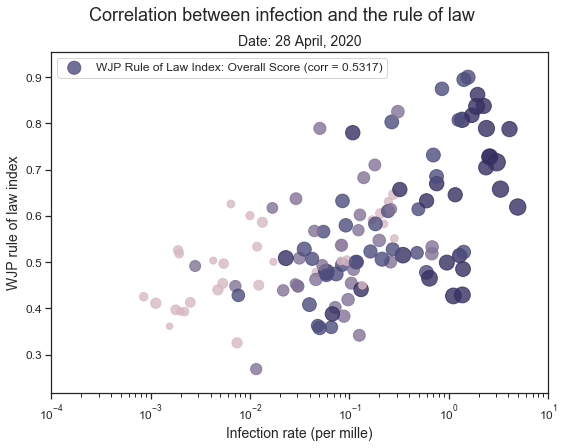

In [113]:
figure_correlation_single(data_world, data_wjp, data_wpp, names_country, fsize = (8, 6), ms = 50, fs = 16, col_index = 0)

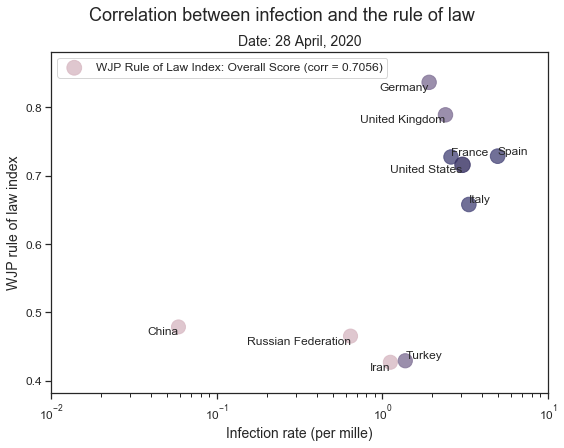

In [114]:
figure_correlation_single(data_world, data_wjp, data_wpp, names_country, 
                          fsize = (8, 6), ms = 40, fs = 16, col_index = 0, flag = 'top')

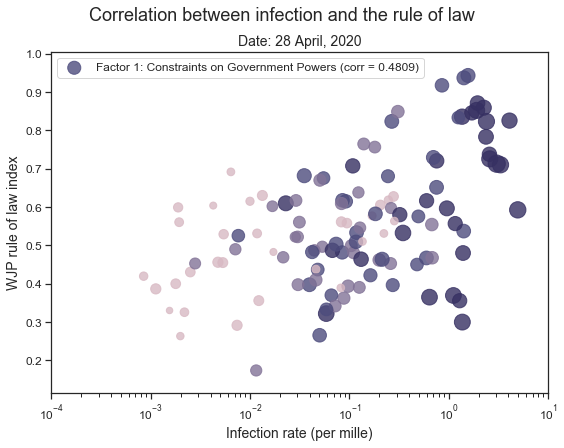

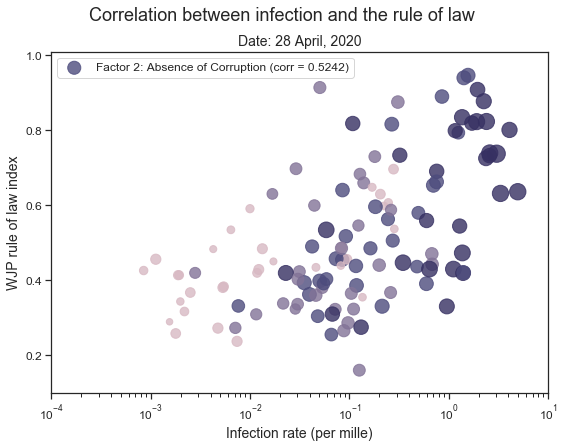

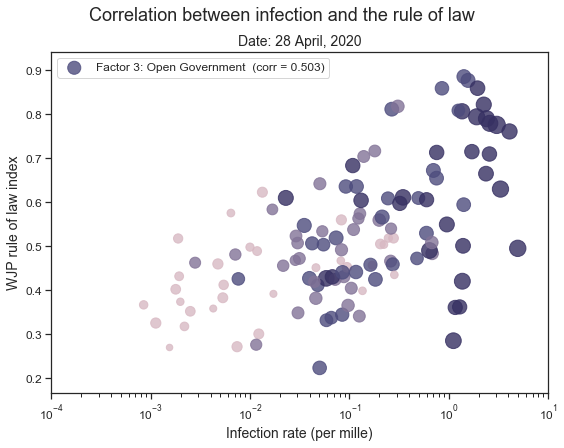

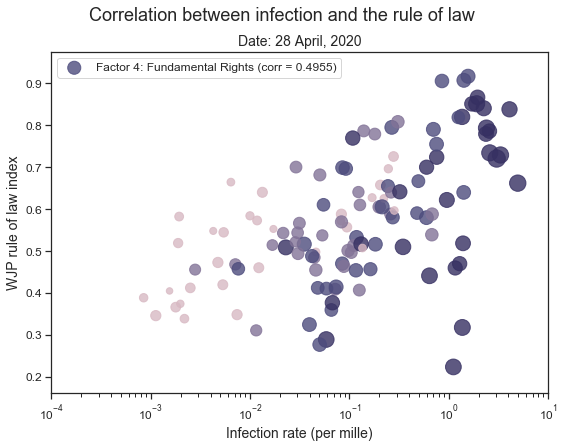

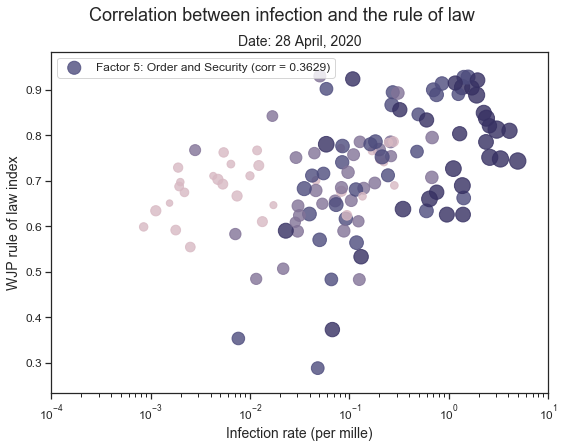

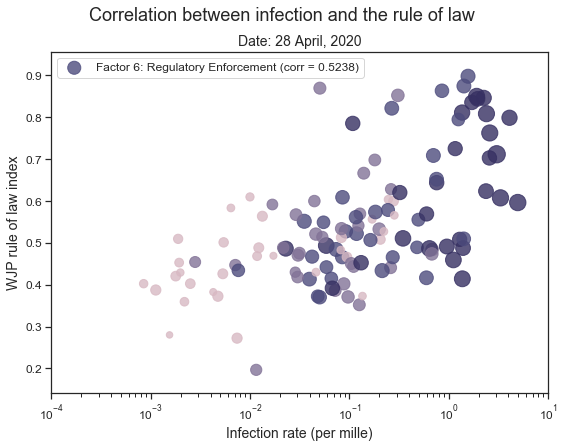

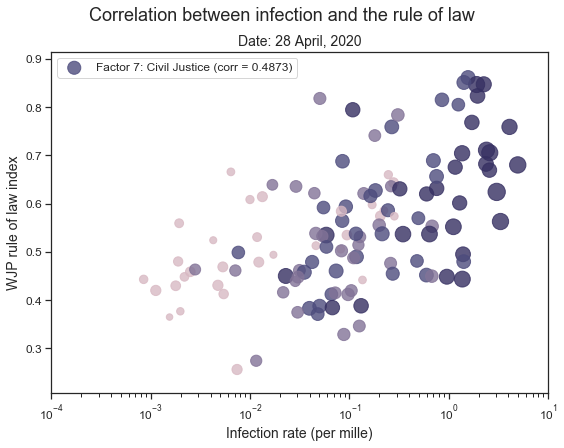

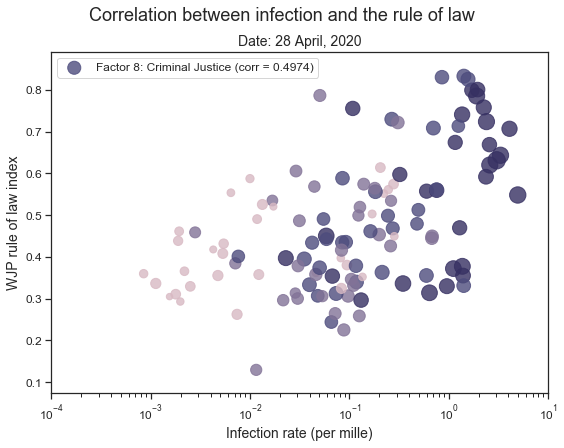

In [115]:
for i in range(1, 9):
    figure_correlation_single(data_world, data_wjp, data_wpp, names_country, fsize = (8, 6), ms = 50, fs = 16, col_index = i)

In [116]:
def figure_correlation(df, df_rule_of_law, df_population, names_country, fsize, ms, fs):
    date_tr = max(df['update_date'] - timedelta(days=0))
    df = df[df['update_date'] == date_tr]
    df = df[df['country/region'].isin(names_country)].reset_index(drop=True)
    df['infection_rate'] = df.apply(lambda row: row['cum_confirmed']/df_population[df_population['country'] == row['country/region']]['population'].tolist()[0], axis=1)
    
    df_rule_of_law = df_rule_of_law[df_rule_of_law['country'].isin(names_country)].reset_index(drop=True)
    
    #fig, axes = plt.subplots(3, 1, figsize = fsize, sharey = False)
    fig = plt.figure(figsize = fsize)
    sns.set_style("ticks")
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    columns = df_rule_of_law.columns.tolist()
    cols = [c for c in df_rule_of_law.columns if (c[0] == 'F') | (c[0] == 'W')]
    for col_index in range(3):
        #ix = np.unravel_index(i, axes.shape)
        #ax = axes[ix]
        if col_index == 0:
            ax = plt.subplot(121)
            column_x = df['infection_rate']
            column_y = df_rule_of_law[cols[col_index]]
            corr = round(column_x.corr(column_y), 4)
            ax.scatter(column_x, column_y, marker = 'o', s = ms + 20, 
                       color = palette[1], label = cols[col_index] + ' (corr = ' + str(corr) + ')', alpha = 0.8)
            names = df.sort_values(by = 'cum_confirmed').reset_index(drop=True).tail(10)['country/region'].tolist()
            names.sort()
            text_x = df.index[df['country/region'].isin(names)].tolist()
            text_y = df_rule_of_law.index[df_rule_of_law['country'].isin(names)].tolist()
            #for pos, name in enumerate(names):
                #ax.annotate(name, (column_x[text_x[pos]], column_y[text_y[pos]]), fontsize = fs - 4)
                
            ax_in = inset_axes(ax, width="50%", height="50%",
                   bbox_to_anchor=(.01, .425, .80, .705),
                   bbox_transform=ax.transAxes, loc=6)
            ax_in.tick_params(labelleft=False, labelbottom=False)
            column_x_in = df[df['country/region'].isin(names)]['infection_rate']
            column_y_in = df_rule_of_law[df_rule_of_law['country'].isin(names)][cols[col_index]]
            corr_in = round(column_x_in.corr(column_y_in), 4)
            ax_in.scatter(column_x_in, column_y_in, marker = 'o', s = ms + 20, 
                       color = palette[2], label = 'corr = ' + str(corr_in), alpha = 0.8)
            for pos, name in enumerate(names):
                if (column_x[text_x[pos]] >= column_x[text_x[names.index('France')]]) & (name != 'United States') or (name =='Turkey') or (name == 'Russian Federation'):
                    ax_in.annotate(name, (column_x[text_x[pos]], column_y[text_y[pos]]),
                                   va = 'bottom', ha = 'left', fontsize = fs - 6)
                else:
                    ax_in.annotate(name, (column_x[text_x[pos]], column_y[text_y[pos]]), 
                                   va = 'top', ha = 'right', fontsize = fs - 6)
                #else:
                    #ax_in.annotate(name, (column_x[text_x[pos]], column_y[text_y[pos]]), 
                                   #va = 'bottom', ha = 'left', fontsize = fs - 4)
            #ax_in.set_xscale('log')
            ax_in.set_xlim(-1.6, 5.2)
            ax_in.set_ylim(0.4, 0.9)
            plt.xticks([])
            plt.yticks([])
            plt.legend(loc = 2)

        else:
            if col_index == 1:
                ax = plt.subplot(222)
            else:
                ax = plt.subplot(224)
            for j, k in enumerate(range(col_index*4 - 3, col_index*4 + 1)):
                column_y = df_rule_of_law[cols[k]]
                corr = round(column_x.corr(column_y), 4)
                ax.scatter(column_x, column_y, marker = 'o', s = ms, 
                           color = palette[j], label = cols[k] + ' (corr = ' + str(corr) + ')', alpha = 0.8)
        if (col_index == 0) | (col_index == 2):
            ax.set_xlabel('Infection rate (per mille)', fontsize = fs - 2)
        if col_index == 0:
            ax.set_ylabel('WJP rule of law index', fontsize = fs - 2)
        ax.set_xscale('log')
        ax.set_xlim(0.0001, 10)
        ax.legend(loc = 'upper left', fontsize = fs - 4, bbox_to_anchor=(0.0, 1), fancybox = True)
    
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        if col_index == 0:
            ax.set_title('Overall', fontsize = fs) 
        else:
            ax.set_title('Group ' + str(col_index), fontsize = fs) 
    #fig.align_ylabels(axes[0:])    
    fig.suptitle('Correlation between infection and the rule of law', fontsize = fs + 2, y = 1.03)
    plt.figtext(0.1, 1.03, 'Date: ' + date_tr.strftime("%d %B, %Y"), ha="center", va="top", fontsize = fs - 2)
    fig.savefig(_Figure_PATH_ + 'rol_general.png', dpi = 400, bbox_inches='tight')
    

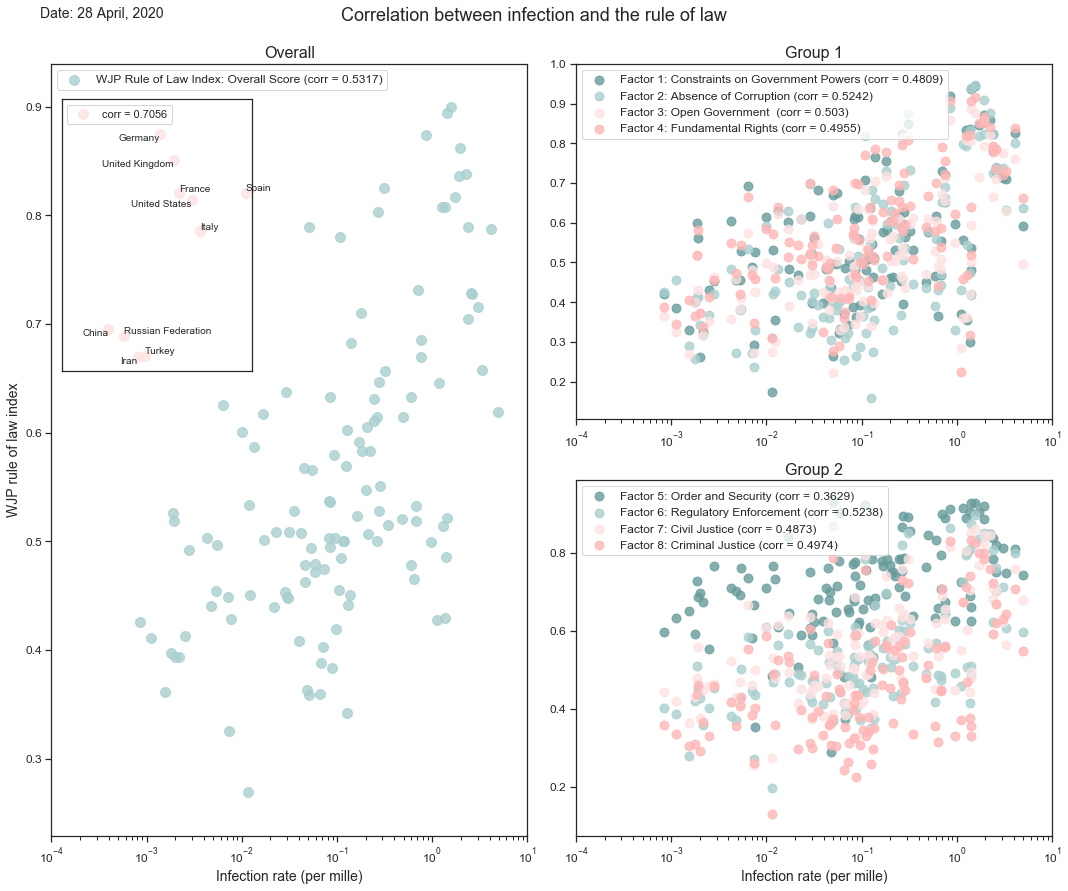

In [117]:
figure_correlation(data_world, data_wjp, data_wpp, names_country, fsize = (15, 12), ms = 80, fs = 16)

In [118]:
# Save to csv files
# Only include the intersection of names of countries
data_wpp[data_wpp['country'].isin(names_country)].reset_index(drop=True).to_csv(_Data_PATH_ + r'data_population.csv', index = False)

In [119]:
data_wjp_posterior = data_wjp[data_wjp['country'].isin(names_country)].reset_index(drop=True)
data_wjp_posterior['cum_confirmed'] = data_wjp_posterior.apply(lambda row: data_world[data_world['country/region'] == row['country']]['cum_confirmed'].tolist()[-1], axis=1)
data_wjp_posterior['infection_rate (per mille)'] = data_wjp_posterior.apply(lambda row: row['cum_confirmed']/data_wpp[data_wpp['country'] == row['country']]['population'].tolist()[0], axis=1)
new_cols = data_wjp_posterior.columns.tolist()
data_wjp_posterior = data_wjp_posterior[new_cols[0:3] + new_cols[-2:] + new_cols[3:-2]]
data_wjp_posterior.to_csv(_Data_PATH_ + r'data_rule_of_law.csv', index = False)

In [120]:
data_world[data_world['country/region'].isin(names_country)].reset_index(drop=True).to_csv(_Data_PATH_ + r'data_infection.csv', index = False)

In [ ]:
# Or if you want to keep the date tag
#data_wjp_posterior.to_csv(_Data_PATH_ + r'data_rule_of_law_' + max(data_world['update_date']).strftime("%Y-%m-%d") + '.csv', index = False)
#data_world[data_world['country/region'].isin(names_country)].reset_index(drop=True).to_csv(_Data_PATH_ + r'data_infection_' + max(data_world['update_date']).strftime("%Y-%m-%d") + '.csv', index = False)
